# Utility functions (from P. Norvig)

In [1]:
# Python 3.x
import re
import numpy as np
import math
import urllib.request

from collections import Counter, defaultdict, namedtuple, deque
from functools   import lru_cache
from itertools   import permutations, combinations, chain, cycle, product, islice
from heapq       import heappop, heappush

def Input(day):
    "Open this day's input file."
    filename = './inputs/input{}'.format(day)
    try:
        return open(filename)
    except FileNotFoundError:
        return urllib.request.urlopen("http://adventofcode.com/2017/day/{}/input".format(day))

def transpose(matrix): return zip(*matrix)

def first(iterable): return next(iter(iterable))

def nth(iterable, n, default=None):
    "Returns the nth item of iterable, or a default value"
    return next(islice(iterable, n, None), default)

cat = ''.join

empty   = frozenset() # Empty set
inf = float('inf')
BIG = 10 ** 999

def grep(pattern, lines):
    "Print lines that match pattern."
    for line in lines:
        if re.search(pattern, line):
            print(line)

def groupby(iterable, key=lambda it: it):
    "Return a dic whose keys are key(it) and whose values are all the elements of iterable with that key."
    dic = defaultdict(list)
    for it in iterable:
        dic[key(it)].append(it)
    return dic

def powerset(iterable):
    "Yield all subsets of items."
    items = list(iterable)
    for r in range(len(items)+1):
        for c in combinations(items, r):
            yield c

# 2-D points implemented using (x, y) tuples
def X(point): return point[0]
def Y(point): return point[1]

def neighbors4(point): 
    "The four neighbors (without diagonals)."
    x, y = point
    return ((x+1, y), (x-1, y), (x, y+1), (x, y-1))

def neighbors8(point): 
    "The eight neighbors (with diagonals)."
    x, y = point 
    return ((x+1, y), (x-1, y), (x, y+1), (x, y-1),
            (x+1, y+1), (x-1, y-1), (x+1, y-1), (x-1, y+1))

def cityblock_distance(p, q=(0, 0)): 
    "City block distance between two points."
    return abs(X(p) - X(q)) + abs(Y(p) - Y(q))

def euclidean_distance(p, q=(0, 0)): 
    "Euclidean (hypotenuse) distance between two points."
    return math.hypot(X(p) - X(q), Y(p) - Y(q))

def trace1(f):
    "Print a trace of the input and output of a function on one line."
    def traced_f(*args):
        result = f(*args)
        print('{}({}) = {}'.format(f.__name__, ', '.join(map(str, args)), result))
        return result
    return traced_f

def astar_search(start, h_func, moves_func):
    "Find a shortest sequence of states from start to a goal state (a state s with h_func(s) == 0)."
    frontier  = [(h_func(start), start)] # A priority queue, ordered by path length, f = g + h
    previous  = {start: None}  # start state has no previous state; other states will
    path_cost = {start: 0}     # The cost of the best path to a state.
    while frontier:
        (f, s) = heappop(frontier)
        if h_func(s) == 0:
            return Path(previous, s)
        for s2 in moves_func(s):
            new_cost = path_cost[s] + 1
            if s2 not in path_cost or new_cost < path_cost[s2]:
                heappush(frontier, (new_cost + h_func(s2), s2))
                path_cost[s2] = new_cost
                previous[s2] = s
    return dict(fail=True, front=len(frontier), prev=len(previous))
                
def Path(previous, s): 
    "Return a list of states that lead to state s, according to the previous dict."
    return ([] if (s is None) else Path(previous, previous[s]) + [s])

# My utility functions

In [2]:
import functools
def myreverse(seq, i0, length):
    nseq = []
    for i in range(length):
        nseq.append(seq[(i0+i)%len(seq)])
    for i in range(length):
        seq[(i0+i)%len(seq)] = list(reversed(nseq))[i]
def knothash(odata, frmt='02x'):
    data = [ord(d) for d in odata] + [17, 31, 73, 47, 23]
    seq = list(range(256))
    pos = 0
    sks = 0
    for i in range(64):
        for l in data:
            myreverse(seq, pos, l)
            pos = (pos + l +sks)%len(seq)
            sks += 1
    dhash = []
    c = ""
    for i in range(16):
        dhash += [functools.reduce(lambda a, b: a^b, seq[16*i:16*(i+1)])]
        c+=format(dhash[i],frmt)
    return c

Tests

In [4]:
assert tuple(transpose(((1, 2, 3), (4, 5, 6)))) == ((1, 4), (2, 5), (3, 6))
assert first('abc') == first(['a', 'b', 'c']) == 'a'
assert cat(['a', 'b', 'c']) == 'abc'
assert (groupby(['test', 'one', 'two', 'three', 'four'], key=len) 
        == {3: ['one', 'two'], 4: ['test', 'four'], 5: ['three']})

# Day 1, challenge 1

Need to obtain summation of all digits in a number such that the next digit is the same (circular)

In [31]:
f = Input(1)
data = f.read()[:-1]
f.close()

In [34]:
suma = 0
for i in range(len(data[:-1])):
    if data[i] == data[i+1]:
        suma = suma+int(data[i])
if data[0] == data[-1]:
    suma = suma+int(data[-1])

In [35]:
suma

1182

## Challenge 2
In this case we obtain summation of all digits such that the digit `len(data)/2` ahead (modulo `len(data)`) is equal to that one. 

In [38]:
suma = 0
for i in range(len(data)):
    j = (i+len(data)//2)%len(data)
    if data[i] == data[j]:
        suma = suma+int(data[i])
suma

1152

# Day 2
## Challenge 1
Find checksum of matrix

In [22]:
f = Input(2)
data = f.read()
data = data.split('\n')[:-1]
data = [d.split('\t') for d in data]
data = [[int(j) for j in i] for i in data]
f.close()

In [23]:
chcksm = 0
for line in data:
    chcksm += max(line) - min(line)
print(chcksm)

41919


## Challenge 2

In [25]:
chcksm = 0
for line in data:
    for j1 in range(len(i)): 
        for j2 in range(len(i)):
            if j2 != j1:
                if i[j1] % i[j2] == 0:
                    chcksm += int(line[j1]/line[j2])
                    break
print(chcksm)

303


# Day 3
## Challenge 1
Objective: Find coordinates of n-th element of a spiral defined as:
    
    17  16  15  14  13
    18   5   4   3  12
    19   6   1   2  11
    20   7   8   9  10
    21  22  23---> ...

In [33]:
def nextpos(num, prevpos):  # bruteforce ftw
    if num == 1:
        return np.array([0,0])
    if num == 2:
        return np.array([1,0])
    if prevpos[0] > abs(prevpos[1]):
        return prevpos + np.array([0, 1])
    elif abs(prevpos[0]) < prevpos[1] or (prevpos[0] == prevpos[1] and prevpos[0]>0):
        return prevpos + np.array([-1, 0])
    elif abs(prevpos[0]) > abs(prevpos[1]) or (prevpos[0] == -1*prevpos[1] and prevpos[1]>0):
        return prevpos + np.array([0, -1])
    else:
        return prevpos + np.array([1, 0])

def pos(num):
    if num == 1:
        return np.array([0,0])
    if num == 2:
        return np.array([1,0])
    prevpos = pos(num-1)
    if prevpos[0] > abs(prevpos[1]):
        return prevpos + np.array([0, 1])
    elif abs(prevpos[0]) < prevpos[1] or (prevpos[0] == prevpos[1] and prevpos[0]>0):
        return prevpos + np.array([-1, 0])
    elif abs(prevpos[0]) > abs(prevpos[1]) or (prevpos[0] == -1*prevpos[1] and prevpos[1]>0):
        return prevpos + np.array([0, -1])
    else:
        return prevpos + np.array([1, 0])

prevpos = np.array([0,0])
for i in range(1, 347991):
    prevpos = nextpos(i+1, prevpos)

In [35]:
cityblock_distance(prevpos)

480

## Challenge 2
Filling each of the coordinate with the sum of all adjacent coordinates (going in spiral and starting with a 1 on `[0,0]`), find what's the value of the first position with a value greater than `347991` (my puzzle input)

In [30]:
poss = {tuple(np.array([0,0])):1}
prevpos = np.array([0,0])
for i in range(1,347991):
    prevpos = nextpos(i+1, prevpos)
    num = 0
    for neig in neighbors8(prevpos):  # these are tuples already, fixed a typo in Norvig's functions.
        if neig in poss:
            num += poss[neig]
    poss[tuple(prevpos)] = num
    if num > 347991:
        print(num)
        break

349975


# Day 4
## Challenge 1
Given a list of strings find duplicates.

In [18]:
f = Input(4)
data = f.read()
data = data.split('\n')[:-1]
data = [d.split(' ') for d in data]
f.close()

In [19]:
res = [any(l.count(x)>1 for x in l) for l in data]
len(res) - sum(res)

451

## Challenge 2
Look for anagrams (need to sort strings!)

In [21]:
data2 = [[cat(sorted(list(x))) for x in l] for l in data]  # ''.join() = cat is not necessary, but I like it.
res = [len(l) > len(set(l)) for l in data2]  # Same as any(l.count(x)>1 for x in l) for l in data but can be faster.
len(res) - sum(res)

223

# Day 5
## Challenge 1

We traverse a sequence $(i_0(0), ..., i_0(n-1)$ the following way:
\begin{align}
&x_0 &= &0\\
&x_{t+1} &= &x_t + i_t(x_t)\\
&i_{t+1}(x_t) &= &i_{t}(x_t) + 1\\
\end{align}

Stop if $x_{t+1} > n-1$

In [36]:
f = Input(5)
data = f.read()
data = data.split('\n')[:-1]
data = [int(i) for i in data]
f.close()

In [37]:
i = 0
nexti = 0
step = 0
while i < len(data):
    nexti = i + data[i]
    data[i] = data[i] + 1
    i = nexti
    step = step+1
print(step)


354121


## Challenge 2

Now $i_{t+1}(x_t) = i_t(x_t) + 1$ if $i_t(x_t) < 3$ and $i_t(x_t) - 1$ else.

In [38]:
f = Input(5)
data = f.read()
data = data.split('\n')[:-1]
data = [int(i) for i in data]
f.close()

In [17]:
i = 0
nexti = 0
step = 0
while i < len(data):
    nexti = i + data[i]
    if data[i] >= 3:
        data[i] = data[i] - 1
    else:
        data[i] = data[i] + 1
    i = nexti
    step = step+1
print(step)


27283023


# Day 6
## Challenge 1 and 2

In [15]:
f = Input(6)
data = f.read().split('\t')
data = [int(i) for i in data]
f.close()
data

[4, 10, 4, 1, 8, 4, 9, 14, 5, 1, 14, 15, 0, 15, 3, 5]

In [16]:
def redist(inp):
    i = 0
    dat = 0
    for j in range(len(inp)):
        if inp[j] > dat:
            i = j
            dat = inp[j]
    inp[i] = 0
    while dat > 0:
        i = (i+1)%len(inp)
        inp[i] += 1
        dat -= 1
    return inp

mydict = {}
mydict[tuple(data)] = 0
step = 0
while True:
    step += 1
    redist(data)
    if tuple(data) in mydict:
        break
    else:
        mydict[tuple(data)] = step
print(step)
print(step-mydict[tuple(data)])
print(data)

12841
8038
[1, 0, 14, 14, 12, 11, 10, 9, 9, 7, 5, 5, 4, 3, 7, 1]


# Day 7
## Challenge 1

In [44]:
from anytree import Node, RenderTree, PostOrderIter

In [57]:
f = Input(7)
data = f.read().split('\n')[:-1]
data = [d.split(' -> ') for d in data]
nodedict = {}
for d in data:
    daux = d[0].split(' ')
    nodedict[daux[0]] = Node(daux[0], weight=int(daux[1][1:-1]))
for d in data:
    daux = d[0].split(' ')
    if len(d) > 1:
        for program in d[1].split(', '):
            nodedict[program].parent = nodedict[daux[0]]
f.close()

In [58]:
print(nodedict['czlmv'].root)
root = nodedict['aapssr']
print(root.depth)
len(root.children)

Node('/aapssr', weight=72)
0


5

## Challenge 2

In [59]:
def BalancedSubtowers(node):
    if len(node.children) == 0:
        return [0]
    weights = [child.weight + sum(BalancedSubtowers(child)) for child in node.children]
    return weights

for node in PostOrderIter(root):
    if len(set(BalancedSubtowers(node))) > 1:
        print(node)
        break

print(BalancedSubtowers(nodedict['pkowhq']))
print(nodedict['pkowhq'].children)

Node('/aapssr/qwada/pkowhq', weight=1187)
[1486, 1492, 1486, 1486]
(Node('/aapssr/qwada/pkowhq/zfrsmm', weight=763), Node('/aapssr/qwada/pkowhq/tlskukk', weight=1464), Node('/aapssr/qwada/pkowhq/fqkbscn', weight=418), Node('/aapssr/qwada/pkowhq/mlafk', weight=38))


# Day 8
## Challenge 1

In [2]:
from collections import defaultdict

In [12]:
f = Input(8)
data = f.read().split('\n')[:-1]
f.close()

In [6]:
regs = defaultdict(lambda: 0)
def parse(line):
    laux = line.split(' ')
    cond = laux[-3:]
    cond[0] = "regs['{}']".format(cond[0])
    if eval(' '.join(cond)):
        if laux[1] == 'inc':
            regs[laux[0]] += int(laux[2])
        else:
            regs[laux[0]] -= int(laux[2])
    return 1


In [7]:
for l in data:
    parse(l)

In [10]:
max(regs.values())

3612

## Challenge 2

In [11]:
regs = defaultdict(lambda: 0)
maxval = 0
for l in data:
    parse(l)
    if max(regs.values()) > maxval:
        maxval = max(regs.values())
maxval

3818

# Day 9
## Challenge 1 and 2

In [20]:
f = Input(9)
data = f.read()
f.close()

In [22]:
score = 0
level = 0
garb = 0
garbcount = 0
# data = "{{<!!>},{<!!>},{<!!>},{<!!>}}"
i = 0
while i < len(data):
    if data[i] == "!":
        i += 1
    else:
        if not garb:
            if data[i] == "{":
                level += 1
                score += level
            elif data[i] == "}":
                level -= 1
                if level < 0:
                    level == 0
            elif data[i] == "<":
                garb = 1
        else:
            if data[i] == ">":
                garb = 0
            else:
                garbcount += 1
    i += 1
print(score)
print(garbcount)

10800
4522


# Day 10
## Challenge 1

In [5]:
f = Input(10)
data = f.read().split(',')
data = [int(d) for d in data]
f.close()
data

[197, 97, 204, 108, 1, 29, 5, 71, 0, 50, 2, 255, 248, 78, 254, 63]

In [6]:
seq = list(range(256))
pos = 0
sks = 0
def myreverse(seq, i0, length):
    nseq = []
    for i in range(length):
        nseq.append(seq[(i0+i)%len(seq)])
    for i in range(length):
        seq[(i0+i)%len(seq)] = list(reversed(nseq))[i]
for l in data:
    myreverse(seq, pos, l)
    pos = (pos + l +sks)%len(seq)
    sks += 1
print(seq[0]*seq[1])

40132


## Challenge 2

In [7]:
f = Input(10)
data = f.read()[:-1]
data = [ord(d) for d in data]
f.close()
data = data + [17, 31, 73, 47, 23]

In [10]:
import functools
seq = list(range(256))
pos = 0
sks = 0
for i in range(64):
    for l in data:
        myreverse(seq, pos, l)
        pos = (pos + l +sks)%len(seq)
        sks += 1
dhash = []
c = ""
for i in range(16):
    dhash += [functools.reduce(lambda a, b: a^b, seq[16*i:16*(i+1)])]
    c+=format(dhash[i],'02x')

c

'35b028fe2c958793f7d5a61d07a008c8'

In [34]:
chr(16)

'\x10'

In [49]:
aux = [65, 27, 9, 1, 4, 3, 40, 50, 91, 7, 6, 0, 2, 5, 68, 22]
functools.reduce(lambda a, b: a^b, aux)

64

# Day 11
## Challenge 1

Learned hex coordinates from [this](https://www.redblobgames.com/grids/hexagons/)

In [5]:

# Copied from reddit, originally used A* with complex numbers, this is much more elegant (learned about hex grids)

f = Input(11)
data = f.read()[:-1].split(',')
x = 0
y = 0
z = 0
f.close()
dists = []

for d in data:
    if d == "n":
        y += 1
        z -= 1
    elif d == "s":
        y -= 1
        z += 1
    elif d == "ne":
        x += 1
        z -= 1
    elif d == "sw":
        x -= 1
        z += 1
    elif d == "nw":
        x -= 1
        y += 1
    elif d == "se":
        x += 1
        y -= 1
    dists.append((abs(x) + abs(y) + abs(z)) / 2)

print ((abs(x) + abs(y) + abs(z)) / 2)
print(max(dists))
# Hex coordinates are cool.

812.0
1603.0


# Day 12
## Challenge 1

In [10]:
from collections import defaultdict
f = Input(12)
data = f.read().split('\n')[:-1]
f.close()
data = [d.split(' <-> ') for d in data]
conns = {}
for d in data:
    conns[int(d[0])] = [int(l) for l in d[1].split(', ')]
conns



{0: [454, 528, 621, 1023, 1199],
 1: [1335, 1563, 1627, 1679],
 2: [353, 689],
 3: [3, 1171],
 4: [1247],
 5: [758, 928, 1260],
 6: [1010],
 7: [570],
 8: [710, 1610],
 9: [9],
 10: [10, 1822],
 11: [473],
 12: [255, 1355, 1999],
 13: [13, 1026],
 14: [113],
 15: [1954],
 16: [679, 918],
 17: [1101, 1637],
 18: [574, 1037],
 19: [481],
 20: [22, 815, 963, 1031],
 21: [1427],
 22: [20, 316, 802],
 23: [1328, 1447, 1708],
 24: [446, 1677],
 25: [25, 217],
 26: [184, 1138],
 27: [142],
 28: [1340],
 29: [954, 1174],
 30: [1185],
 31: [112, 1111],
 32: [1851],
 33: [662],
 34: [848],
 35: [315, 1983],
 36: [239],
 37: [422, 871, 1903],
 38: [1450, 1497],
 39: [923, 1652],
 40: [201, 434],
 41: [1878],
 42: [192, 1233],
 43: [1457],
 44: [499, 961],
 45: [1056],
 46: [302],
 47: [100, 1921],
 48: [1532],
 49: [728, 1028, 1201, 1301],
 50: [1662],
 51: [1186, 1773],
 52: [228, 1168, 1873],
 53: [413, 1111],
 54: [956],
 55: [477],
 56: [98],
 57: [1849, 1960],
 58: [440],
 59: [1115, 1389],


In [11]:
conn0 = set(conns[0])
l = 0
laux = len(conn0)
currlevel = conns[0][:]
newlevel = []
while laux > l:
    l = laux
    for num in currlevel:
        conn0.update(set(conns[num]))
        newlevel += conns[num]
    newlevel = list(set(newlevel))
    currlevel = newlevel[:]
    newlevel = []
    laux = len(conn0)

print(l)


378


## Challenge 2

In [27]:
visited = len(conns)*[0]
conncomp = 0
def dfs(num):
    for connum in conns[num]:
        if not visited[connum]:
            visited[connum] = 1
            dfs(connum)

for num in conns:
    if not visited[num]:
        visited[num] = 1
        conncomp += 1
        dfs(num)
print(conncomp)

204


# Day 13
## Challenge 1

In [25]:
from collections import defaultdict
f = Input(13)
data = f.read().split('\n')[:-1]
# data = ['0: 3', '1: 2', '4: 4', '6: 4']
f.close()
scann = defaultdict(lambda : 0)
for d in data:
    scann[int(d.split(': ')[0])] = int(d.split(': ')[1])
n = max(scann.keys()) + 1
severity = 0
for j in scann:
    if j%((scann[j]-1)*2) == 0:
        severity += j*scann[j]
severity

1728

## Challenge 2

In [26]:
delay = 0
while delay > -1:
    severity = 0 
    for j in scann:
        if (delay+j)%((scann[j]-1)*2) == 0:
            severity += j*scann[j] + 1
            if severity > 0:
                break
    if severity == 0:
        print(delay)
        break
    delay = delay+1

3946838


# Day 14
## Challenge 1
Note: If hash is any good, bits should look like random with $p = 0.5$. Therefore sum of squares with a one should be around $128^2 / 2 = 8192$. 

(Note2: The hash has other problems, but also cool stuff: [see this](https://www.reddit.com/r/adventofcode/comments/7it50b/day_10_part_2_cryptanalysis/))

In [100]:
data = 'uugsqrei'
squares = []
for i in range(128):
    hsh = knothash(data+'-'+str(i), frmt='08b')
    squares += [[int(h) for h in hsh]]
squares = np.array(squares)
print("{}, yay!".format(np.sum(squares)))

8194, yay!


In [91]:
indices = np.where(squares == 1)
indices = list(np.array(indices).T)
indices = [tuple(i) for i in indices] # Note: Sparse version of matrix
visited = [0]*len(indices) # I'm basically looking at connected components without creating the dictionary first
def matdfs(pos):
    for neigh in neighbors4(indices[pos]):
        try:
            npos = indices.index(neigh)
            if not visited[npos]:
                visited[npos] = 1
                matdfs(npos)
        except ValueError as e:
            pass
conncomp = 0
for ind in range(len(indices)):
    if not visited[ind]:
        visited[ind] = 1
        conncomp += 1
        matdfs(ind)
conncomp

1141

Looking a bit at how random are each of these bits?

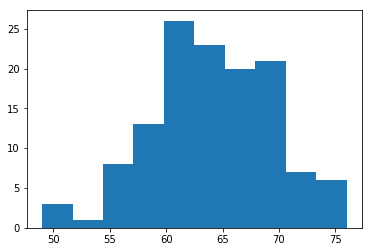

In [104]:
import matplotlib.pyplot as plt

plt.hist(np.sum(squares, axis=0))
plt.show()

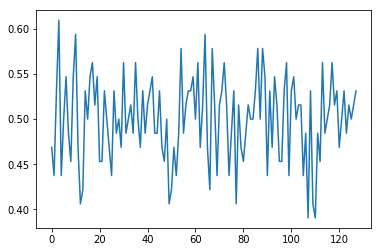

In [108]:
plt.plot(np.sum(squares, axis = 1)/128)
plt.show()

# Day 15
## Challenge 1

In [18]:
genA0 = 679
genB0 = 771
factA = 16807
factB = 48271
div = 2147483647

def genA():
    x = genA0
    while True:
        x *= factA
        x %= div
        yield x
def genB():
    x = genB0
    while True:
        x *= factB
        x %= div
        yield x
        
A = genA()
B = genB()
counteq = 0
for i in range(40*10**6):
    a = next(A)
    b = next(B)
    if (a & 0xFFFF) == (b & 0xFFFF):
        counteq+=1

counteq

626

In [20]:
newcounteq = 0
judgecount = 0

def genA():
    x = genA0
    while True:
        x *= factA
        x %= div
        if x % 4 == 0:
            yield x

def genB():
    x = genB0
    while True:
        x *= factB
        x %= div
        if x % 8 == 0:
            yield x

A = genA()
B = genB()
for jc in range(5*10**6):
    a = next(A)
    b = next(B)
    newcounteq += ((a & 0xFFFF) == (b & 0xFFFF))
newcounteq

306

# Day 16
## Challenge 1

In [218]:
import string
f = Input(16)
data = f.read()[:-1].split(',')
f.close()

In [222]:
class Permutation(object):
    def __init__(self, lst0, lst):
        self.ref = lst0[:]
        self.l = len(lst0)
        self.perm = {lst0[i]:lst[i] for i in range(len(lst0))}
    def t(self, i1, i2):
        aux1, aux2 = self.perm[i1], self.perm[i2]
        self.perm[i1], self.perm[i2] = aux2, aux1
    
    def composeright(self, perm2):
        self.perm = {i:perm2.perm[self.perm[i]] for i in self.perm}
    
    def composeleft(self, perm2):
        self.perm = {i:self.perm[perm2.perm[i]] for i in perm2.perm}
    def __repr__(self):
        return self.perm.__repr__()

def nextstr(stri, permind, permstr):
    straux = list(stri)
    straux = [permstr.perm[c] for c in straux]
    return ''.join(straux[permind.perm[i]] for i in permind.perm)
    

In [223]:
# Generate permutations
permind = Permutation(range(l), range(l))
permstr = Permutation(list(string.ascii_lowercase[:l]), list(string.ascii_lowercase[:l]))

for inst in data:
    if inst[0] == 's':
        off = int(inst[1:])
        auxperm = Permutation(range(l), [(i - off)%l for i in range(l)])
        permind.composeleft(auxperm)
    elif inst[0] == 'x':
        i1, i2 = [int(i) for i in inst[1:].split('/')]
        permind.t(i1, i2)
    elif inst[0] == 'p':
        c1, c2 = [c for c in inst[1:].split('/')]
        for (k,v) in permstr.perm.items():
            if v == c1:
                permstr.perm[k] = c2
            if v == c2:
                permstr.perm[k] = c1

print(permind, permstr)


{0: 15, 1: 1, 2: 12, 3: 2, 4: 8, 5: 7, 6: 5, 7: 14, 8: 6, 9: 4, 10: 13, 11: 10, 12: 3, 13: 0, 14: 11, 15: 9} {'a': 'l', 'b': 'a', 'c': 'd', 'd': 'e', 'e': 'f', 'f': 'b', 'g': 'i', 'h': 'k', 'i': 'g', 'j': 'j', 'k': 'c', 'l': 'o', 'm': 'm', 'n': 'p', 'o': 'h', 'p': 'n'}


In [224]:
str0 = string.ascii_lowercase[:l]
print(nextstr(str0, permind, permstr))

namdgkbhifpceloj


## Challenge 2


In [228]:
str1 = nextstr(str0, permind, permstr)
cyc = 1
while str1 != str0:
    str1 = nextstr(str1, permind, permstr)
    cyc+=1
print(cyc)

60


In [229]:
numreps = 10**9 % cyc
for i in range(numreps):
    str1 = nextstr(str1, permind, permstr)
print(str1)

ibmchklnofjpdeag


# Day 17
## Challenge 1

In [231]:
def spinlock(lst, val, curpos, step=324):
    i = (curpos + step) % len(lst) + 1
    lst.insert(i, val)
    return i

lst = [0]
curpos = 0

for i in range(1, 2018):
    curpos = spinlock(lst, i, curpos)
print(lst[curpos+1])


1306


## Challenge 2
Looking for last time in 50 million iterations in which `curpos == 1`

In [232]:
curpos = 0
l = 1
step = 324
curval = 0
for i in range(50*10**6):
    curpos = (curpos + step) % l + 1 
    l += 1
    if curpos == 1:
        curval = i+1
curval

20430489

# Day 18
## Challenge 1

In [291]:
from collections import defaultdict
f = Input(18)
data = f.read().split('\n')[:-1]
f.close()
insts = [d.split(' ') for d in data]


In [311]:
i = 0
regs = defaultdict(lambda : 0)
def run(insts, i, regs):
    def getval(k):
        try:
            return int(k)
        except ValueError as e:
            return regs[k]
    ret = np.nan
    isrcv = 0
    newi = i+1
    if insts[i][0] == 'rcv':
        if regs[insts[i][1]] > 0:
            ret = regs['last']
            isrcv = 1
    elif insts[i][0] == 'snd':
        regs['last'] = regs[insts[i][1]]
    elif insts[i][0] == 'set':
        regs[insts[i][1]] = getval(insts[i][2])
    elif insts[i][0] == 'add':
        regs[insts[i][1]] += getval(insts[i][2])
    elif insts[i][0] == 'mul':
        regs[insts[i][1]] *= getval(insts[i][2])
    elif insts[i][0] == 'mod':
        try:
            regs[insts[i][1]] %= getval(insts[i][2])
        except ZeroDivisionError as e:
            pass
    elif insts[i][0] == 'jgz':
        if regs[insts[i][1]] > 0:
            newi = i + getval(insts[i][2])
    return [newi, ret, isrcv]
while i < len(insts):
    [i, ret, isrcv] = run(insts, i, regs)
    if isrcv:
        print(ret)
        break

2951


## Challenge 2

In [310]:
from collections import deque
i0 = 0
i1 = 0
regs0 = defaultdict(lambda : 0)
regs1 = defaultdict(lambda : 0)
regs0['p'] = 0
regs1['p'] = 1
regs0['buf'] = deque([])
regs1['buf'] = deque([])
sent1 = 0
wait0 = 0
wait1 = 0
def run(insts, i, regs):
    def getval(k):
        try:
            return int(k)
        except ValueError as e:
            return regs[k]
    ret = np.nan
    regs['wait'] = 0
    newi = i+1
    if insts[i][0] == 'rcv':
        try:
            regs[insts[i][1]] = regs['buf'].popleft()
        except IndexError:
            newi = i
            regs['wait'] = 1
    elif insts[i][0] == 'snd':
        ret = getval(insts[i][1])
    elif insts[i][0] == 'set':
        regs[insts[i][1]] = getval(insts[i][2])
    elif insts[i][0] == 'add':
        regs[insts[i][1]] += getval(insts[i][2])
    elif insts[i][0] == 'mul':
        regs[insts[i][1]] *= getval(insts[i][2])
    elif insts[i][0] == 'mod':
        try:
            regs[insts[i][1]] %= getval(insts[i][2])
        except ZeroDivisionError as e:
            pass
    elif insts[i][0] == 'jgz':
        if getval(insts[i][1]) > 0:
            newi = i + getval(insts[i][2])
    return [newi, ret]

while not (regs0['wait'] and regs1['wait']):
    while not regs0['wait']:
        [i0, ret0] = run(insts, i0, regs0)
        if not np.isnan(ret0):
            regs1['buf'].append(ret0)
    if len(regs1['buf']) > 0:
        regs1['wait'] = 0
    while not regs1['wait']:
        [i1, ret1] = run(insts, i1, regs1)
        if not np.isnan(ret1):
            regs0['buf'].append(ret1)
            sent1 += 1
    if len(regs0['buf']) > 0:
        regs0['wait'] = 0
print(sent1)

7366
